# Graph analytics project

_Done by: Nasserallah EL MASSAOUDI - Rim BOUKBA_<br>
This project aims to utilize what we learned during the course _Graph analytics_ in order to do a descriptive analysis of twitter data related to the NFT world.

In [1]:
#Importing necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle

## Importing data :
The data we will use for this project is streamed data from the twitter API, corresponding to tweets related to NFTs, we will use a subset of this dataset in order to create a graph where the entities will be users that mentioned other users, the pair is composed of the user who wrote the tweet and a user he mentioned in the said tweet, the edges will be defined the frequency of mentions.

In [5]:
#reading the jsonl file

tweets = []
with open("stream__NFT.jsonl","r") as source:
    for tweet in source:
        tweets.append(json.loads(tweet))

In [6]:
len(tweets)

33316

We have 33316 tweets, this is a considerably huge number and with consideration to our low processing capacity, we will only focus on a subset of the streaming result.

In [7]:
tweets = tweets[:3500]

In the next block of code, we will filter out the data, only keeping information that is relevant to us, while also forming pairs of (user, mentioned user)

In [10]:
pairs = []
for tweet in tweets:
    try:
        username = tweet["user"]["screen_name"]
    except:
        continue
    for mentioned in tweet["entities"]["user_mentions"]:
        pairs.append((username,mentioned["screen_name"]))
pairs[:5]

[('NFTKING0071', 'nft_universal_'),
 ('couprangcoups', 'streethers'),
 ('aboynamedCloud', 'diverse'),
 ('serguz85', 'brave0nft'),
 ('stackstl', 'karaholiday17')]

## Data processing:
In the following few blocks, we will process the data that we have in order to create a graph structure that we will run our analysis on.

In [11]:
data = pd.DataFrame(pairs,columns=["from","to"])
data.head()

,from,to
0,NFTKING0071,nft_universal_
1,couprangcoups,streethers
2,aboynamedCloud,diverse
3,serguz85,brave0nft
4,stackstl,karaholiday17


Now we will group by "from" and "to", then aggregate the dataset by the size of the resulting groups in order to retrieve the frequency of mentions by a user to a user

In [15]:
g_data = data.groupby(["from","to"]).size().reset_index()
g_data.columns = ["from","to","freq"]
g_data.head()

,from,to,freq
0,0306Aditya,ProjectGalaxyHQ,1
1,0306Aditya,SoulRebornGame,1
2,04Valia1987,Min0taur0_,1
3,0OfeRkLmEhG2Ol3,streethers,1
4,0x0_art_br,NFTzf,1


Saving the data for later use:

In [21]:
g_data.to_csv("NFT_g_data.csv")

# Creating and visualizing the graph
Our data are ready to be converted into a graph using the networkx library

In [22]:
graph = nx.from_pandas_edgelist(g_data,source="from",target="to",edge_attr="freq")

In [23]:
nx.info(graph)

'Graph with 3791 nodes and 4025 edges'

We will save the graph to a file in order to avoid re-doing the processing part every time

In [37]:
nx.write_gml(graph,"NFT_GRAPH.gml")

In order to visualise the graph, we will create a layout object, that will calculate the positions of the elements of the graph using an algorithm (In our case, the Kusama Kawai algorithm)

In [24]:
layout = nx.kamada_kawai_layout(graph)

The layout calculation took about 10mins, so in order to avoid re-calculating it in the future, we will use pickle to dump it into a file

In [30]:
pickle.dump(layout,open("LAYOUT_PCKL","wb"))

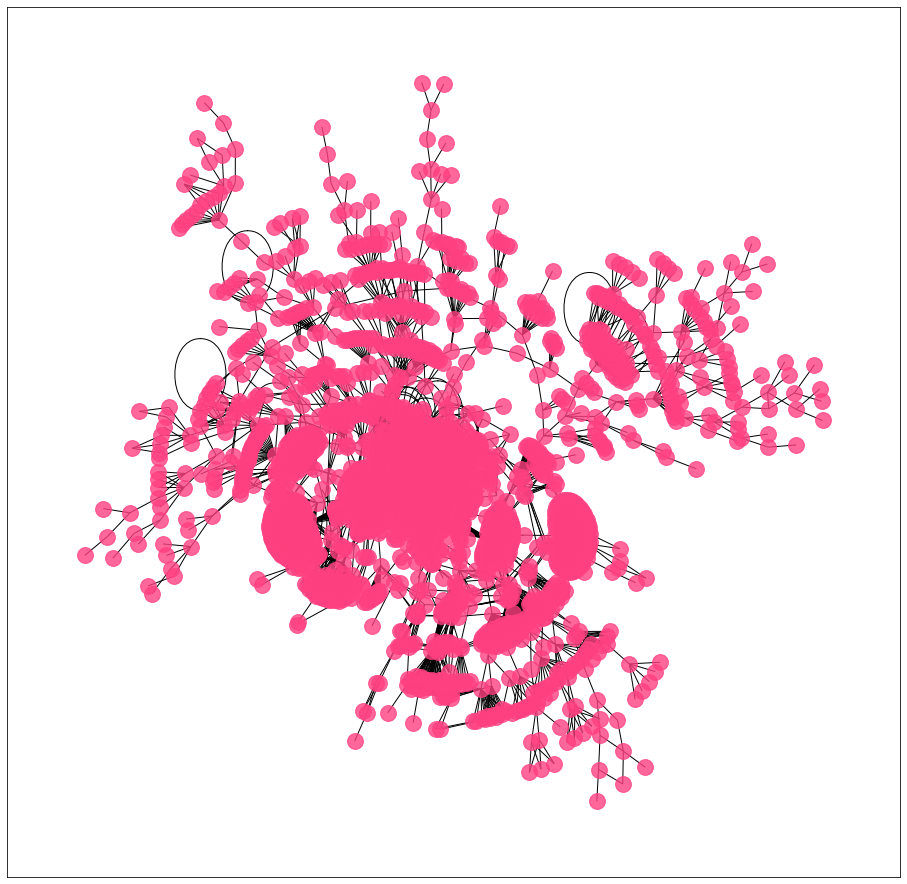

In [36]:
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(graph,pos=layout,alpha=0.8,node_color="#ff4080",node_size=250)
nx.draw_networkx_edges(graph,pos=layout)
plt.show()

Another way we could visualise this structure is using a library called pyvis

In [ ]:
%pip install pyvis

In [29]:
from pyvis.network import Network

In [ ]:
network = Network(notebook=True)
network.from_nx(graph)
network.show("output/output.html")

Pyvis enables us to interact with the graph, throughout a web page (output.html), and while exploring it in our case we were able to discover interesting relationships, first of all here is a macro view of the whole graph

![output/osc0.png](output/osc0.png)

We can see a significant concentration in some parts of the graph, with other parts seperated, if we zoom into the significant parts, we can see some NFT projects that have been able to relatively gather attention in the time of the data acquisition, for example :

![output/osc1.png](output/osc1.png)

We see a close relationship between karaholiday17 and EtherealartNFT, as an interpretation, this could mean that karaholiday17 is part of the team that created and/or is promoting EtherealartNFT, and this turn out to be the case as is shown by this tweet  

![output/scn0.png](output/scn0.png)

These promoters play a big role in gathering attention for a particular project, but  they are in no necessary, as shows this case:

![output/osc2.png](output/osc2.png)

Diverse is taking matters into his own hands, and has a very imposing pull

![output/scn1.png](output/scn1.png)

## Descriptive analysis

In [23]:
graph = nx.read_gml("NFT_GRAPH.gml")
layout = pickle.load(open("LAYOUT_PCKL","rb"))

### Macro-level structural analysis

In [3]:
nx.density(graph)

0.0005602771179345053

As we can see, and confirm with previous visualisations, our data is not very dense, this means that we lack a lot of edges, and not all of our data is interconnected

In [4]:
nx.algorithms.average_clustering(graph)

0.02163006254275049

2% tendency for a node to create clusters

In [6]:
nx.assortativity.degree_assortativity_coefficient(graph)

-0.15970285402809092

### Micro-level structural analysis

In [9]:
graph_degree = dict(nx.degree(graph,weight="freq"))

In [14]:
graph_degree_df = pd.DataFrame.from_dict(graph_degree,orient="index",columns=["degree"]).sort_values('degree',ascending=False)

In [17]:
graph_degree_df.head(12)

,degree
diverse,249
CrazySnails,218
LostEdenNFT,166
NotRazorX,109
streethers,100
KarafuruNft,81
HYPEALIENS,80
JayIttichai,75
MoonPromos,74
HalfEatenCrew,73


This shows us the highly connected nodes in our graph, for instance, diverse is the most connected node in our graph.

## Community detection
In order to explore more groups, we will apply a community detection algorithm to our graph, and then visualize the results.

In [19]:
import community

In [26]:
partitions = community.best_partition(graph)
par = pd.DataFrame.from_dict(partitions,orient="index").reset_index()
par.columns = ["user","partition"]
val = list(par.partition)

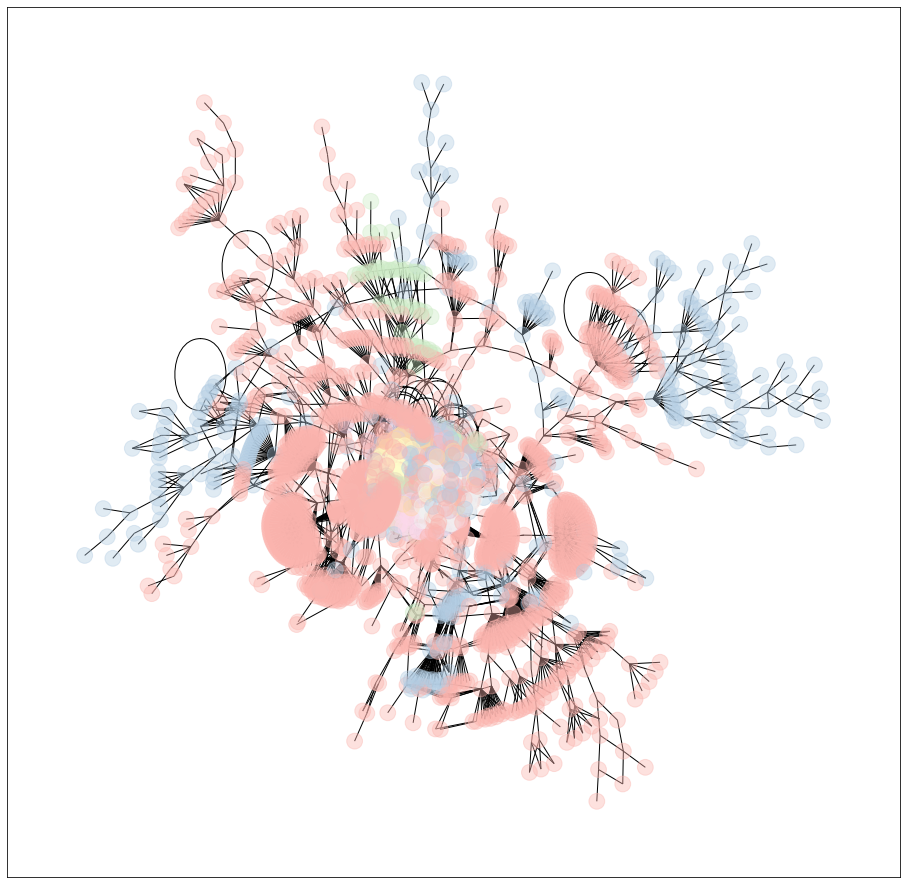

In [25]:
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(graph,pos=layout,alpha=0.4,node_color=val,node_size=250,cmap=plt.cm.Pastel1)
nx.draw_networkx_edges(graph,pos=layout)
plt.show()

This visualization enables us to see different communities that may be interested in different kinds of NFT related projects

## Core-periphery

In [39]:
graph.remove_edges_from(nx.selfloop_edges(graph))
nx.core_number(graph).values()

dict_values([2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 3, 3, 3, 3, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 3, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 

Our data do not have a core periphery structure, but the core number shows that we do have different cores that link different communities, taught the core is not unique